# Set Up

In [2]:
# Common imports
import numpy as np
import os

# To make this notebook's output stable across runs
np.random.seed(42)

# To plot figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

## MNIST 
En el libro se utiliza la función `fetch_mldata` que ya no funciona más con sklearn. Ahora se usa la función `fetch_openml` pero en esta es necesario ordenar los datos para obtener el mismo resultado que el libro.

In [3]:
def sort_by_target(mnist):
    reorder_train = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[:60000])]))[:,1]
    reorder_test = np.array(sorted([(target, i) for i, target in enumerate(mnist.target[60000:])]))[:,1]
    mnist.data[:60000] = mnist.data[reorder_train]
    mnist.target[:60000] = mnist.target[reorder_train]
    mnist.data[60000:] = mnist.data[reorder_test + 60000]
    mnist.target[60000:] = mnist.target[reorder_test + 60000]

In [4]:
# Fetch the data using sklearn and then sort the data as in the book
try:
    from sklearn.datasets import fetch_openml
    mnist = fetch_openml('mnist_784', version=1, cache=True)# This is how you fetch the dataset
    mnist.target = mnist.target.astype(np.int8) # Target are fetched as an array
    sort_by_target(mnist)
except ImportError:
    from sklearn.dataset import fetch_mldata
    mnist = fetch_mldata('MNIST original')
mnist['data'], mnist['target']

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([0, 0, 0, ..., 9, 9, 9], dtype=int8))

In [5]:
# Dataset dimensions
X, y = mnist['data'], mnist['target']
X.shape, y.shape

((70000, 784), (70000,))

The datasets contains 70000 images 28x28 pixels (arrays of 784 elemnts). Also there's a 70000 labels vector.
if you explore more deeply you'll see that each elements of the data is a value between 0 and 255.

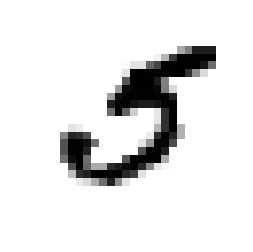

In [6]:
some_digit = X[36000]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap=mpl.cm.binary, interpolation='nearest') 
# cmap for color and interpolation for definition
plt.axis('off')
plt.show()

In [7]:
y[36000]

5

In [8]:
# Dividing the data into trainset and testset 60000/10000
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [9]:
# Shuffle the data / unsorting for cross-validation
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## Binary Classifiers
Evaluaremos la clasificación de si un número es 5 o no.

In [10]:
# Creating the boolean label for: 5 or not
y_train_5 = (y_train == 5) # Boolean label: True if it's a 5, False for all the others.
y_test_5 = (y_test == 5)

### SDG Classifier

In [11]:
# Call, and train the classifier
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42) # max_iter and tol just for same results
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=5,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=42, shuffle=True, tol=-inf,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
# Evaluating the prediction in trained data
sgd_clf.predict([some_digit])

array([ True])

## Perfomance Measures

In [13]:
# Accuracy of the classifier
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.9502 , 0.96565, 0.96495])

Tiene sobre 95% de **accuracy** en todas las folds.
Intentemos con un clasificador que nunca entregue 5.

In [14]:
from sklearn.base import BaseEstimator
class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)

In [15]:
# Accuracy of naive classifier to show skewed data problems with accuracy
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.909  , 0.90715, 0.9128 ])

Se observa que para **skewed data** no es conveniente usar el accuracy.
Intentaremos ahora con la **Confusion Matrix**.

### Confusion Matrix

In [16]:
# Predictions for confusion matrix and so on.
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [17]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53272,  1307],
       [ 1077,  4344]])

### Precision, recall and F1

In [18]:
# Precision and recall
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred), 4344/(4344+1307), recall_score(y_train_5, y_train_pred), 4344/(4344+1077)

(0.7687135020350381, 0.7687135020350381, 0.801328168234643, 0.801328168234643)

El clasificador estará contestando correctamente un 76,8% y solo detectara el 80,1% de los números 5. En el resultado superior se puede ver como la fórmula implementada en scikit es igual a la fórmula matemática.

Podemos calcular también el **F1 Score**, que es una combinación entre ambas métricas.

In [19]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7846820809248555

Es posible también aumentar el threshold para poder ganar precisión (perdiendo recall) o disminuirlo para aumentar el recall (disminuyendo la precisión). La función siguiente entrega el score de cierta data.

In [20]:
# Score for some random digit
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([161855.74572176])

In [22]:
# Changing the threshold to a higher value
threshold = 200000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Como elegir un buen threshold? Podemos graficar las funciones precision and recall. La siguiente función nos entrega los scores de cada uno de los datos.

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")

In [28]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

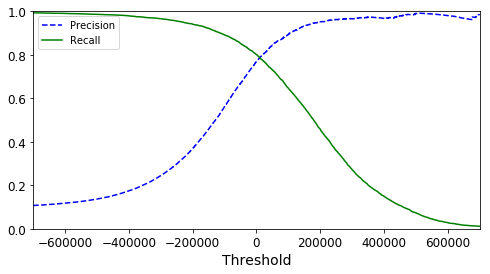

In [42]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
plt.figure(figsize=(8,4)) # wider graph
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.xlim([-700000, 700000]) #put x limits to the plot
plt.show()

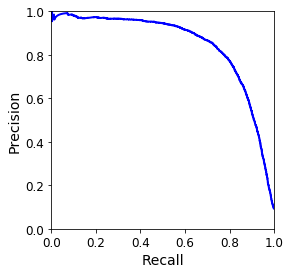

In [40]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.axis([0, 1, 0, 1])
    
plt.figure(figsize=(4, 4))
plot_precision_vs_recall(precisions, recalls)
plt.show()

La precisión comienza a caer drásticamente justo antes del 80% porciento de recall. En este caso una buena opción sería tomar un valor justo antes de que esto ocurra.

Veámos como funciona cuando tomamos un 90% precision

In [45]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90), recall_score(y_train_5, y_train_pred_90)

(0.8659205116491548, 0.6993174691016417)

### ROC Curve

In [47]:
from sklearn.metrics import roc_curve
ftp, tpr, thresholds = roc_curve(y_train_5, y_scores)

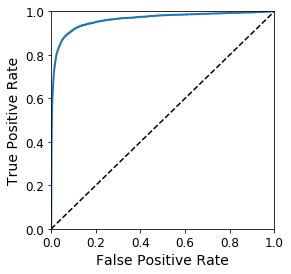

In [50]:
def plot_roc_curve(ftp, tpr):
    plt.plot(ftp, tpr, linewidth=2)
    plt.plot([0,1], [0,1], 'k--') # Random Classifier
    plt.axis([0, 1, 0, 1])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    
plt.figure(figsize=(4, 4))
plot_roc_curve(ftp, tpr)
plt.show()

Queremos estar tan lejos de la linea del random classifier como se pueda hacia la izquierda-arriba. Otra medida útil es el **ROC AUC (*roc area under curve*)** en donde un clasificador perfecto tendría ROC AUC 1 mientras que un random tendría 0.5

In [51]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9624496555967156